In [1]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
import seaborn as sns

# Add project root to sys.path so we can import custom modules from anywhere
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.utility import *



In [2]:
pipeline = Pipeline([
    #("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("remove_collinear", CollinearityRemover(threshold=10.0)),
    #("dim_reduction", PCA(n_components=3)),
    ("model", RandomForestClassifier(random_state=42))
])

In [5]:
iris = sns.load_dataset("iris")
X = iris.drop(columns=["species"])
y = iris["species"]

out = DataFramePreprocessor().dataset_overview(X=iris, corr_threshold=0.8)
out['stats']

TypeError: dataset_overview() missing 1 required positional argument: 'self'

Predicted   setosa  versicolor  virginica
Actual                                   
setosa          50           0          0
versicolor       0          50          0
virginica        0           0         50


<Axes: xlabel='Predicted', ylabel='Actual'>

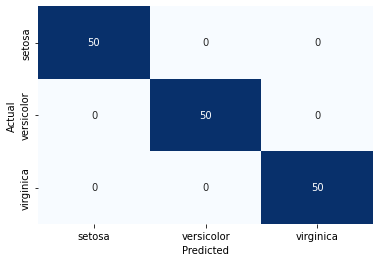

In [ ]:
pipeline.fit(X, y)
y_pred = pipeline.predict(X)
#conf_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
conf_matrix = pd.crosstab(y, y_pred, rownames=['Actual'], colnames=['Predicted'])
print(conf_matrix)  
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)